# How to: Use EMIT Quality Data

There are two quality layers associated with L2A Reflectance Product contained within the L2A Mask file. The `mask` variable contains 6 binary flag bands (1-5, 8) which should be excluded from analysis, and two data bands (6,7).

The second `band_mask` variable indicates whether or not any given wavelength of any given pixel is interpolated. Interpolation occurs either due to a focal plane array bad pixel, or from saturation. This data is provided as a packed unsigned integer array with 36 elements.

**Requirements:**
+ A NASA [Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download EMIT data   
+ Selected the `emit_tutorials` environment as the kernel for this notebook.
  + For instructions on setting up the environment, follow the the `setup_instructions.md` included in the `/setup/` folder of the repository.  

**Learning Objectives**
+ How to build a mask using the quality flags from an EMIT L2A Mask file
+ How to build a mask by unpacking the `band_mask` data
+ How to apply the band and quality masks to another EMIT file.

## 1. Using EMIT Quality Flag Data
Import the required Python libraries.

In [1]:
# Import Packages
import os
import earthaccess
import netCDF4 as nc
from osgeo import gdal
import numpy as np
import xarray as xr
import hvplot.xarray
import holoviews as hv
import sys
sys.path.append('../modules/')
import emit_tools

Login to your NASA Earthdata account and create a `.netrc` file using the `login` function from the `earthaccess` library. If you do not have an Earthdata Account, you can create one [here](https://urs.earthdata.nasa.gov/home). 

In [2]:
earthaccess.login(persist=True)

For this notebook we will download the files necessary using `earthaccess`. You can also access the data in place or stream it, but this can slow due to the file sizes. Provide URLs for an EMIT L2A Reflectance and L2A Mask.

In [3]:
urls = ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20220903T163129_2224611_012/EMIT_L2A_RFL_001_20220903T163129_2224611_012.nc',
        'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20220903T163129_2224611_012/EMIT_L2A_MASK_001_20220903T163129_2224611_012.nc']
# Get requests https Session using Earthdata Login Info
fs = earthaccess.get_requests_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
for url in urls:
    granule_asset_id = url.split('/')[-1]
    # Define Local Filepath
    fp = f'../../data/{granule_asset_id}'
    # Download the Granule Asset if it doesn't exist
    if not os.path.isfile(fp):
        with fs.get(url,stream=True) as src:
            with open(fp,'wb') as dst:
                for chunk in src.iter_content(chunk_size=64*1024*1024):
                    dst.write(chunk)

Set a filepath for the reflectance and mask files downloaded.

In [4]:
fp = '../../data/EMIT_L2A_RFL_001_20220903T163129_2224611_012.nc'
fp_mask = '../../data/EMIT_L2A_MASK_001_20220903T163129_2224611_012.nc'

The most efficient way to utilize the mask is to apply it before orthorectification because the orthorectified datasets take up more space. To apply a  mask using the L2A Mask file, we want to open it, specify which bands to use in construction of a mask, and then apply the mask.

To do this, first take a look at what each band will mask by reading in the `sensor_band_parameters` group from the mask file as an `xarray.dataset` then converting to a dataframe.

>Note: In the user guide, the bands are indexed as 1-8 not 0-7 as used here.

In [5]:
mask_parameters_ds = xr.open_dataset(fp_mask,engine = 'h5netcdf', group='sensor_band_parameters')
mask_key = mask_parameters_ds['mask_bands'].to_dataframe()
mask_key

,mask_bands
bands,
0,Cloud flag
1,Cirrus flag
2,Water flag
3,Spacecraft Flag
4,Dilated Cloud Flag
5,AOD550
6,H2O (g cm-2)
7,Aggregate Flag


# Visualizing the mask

Let's start by reviewing some of the content of these bands, and seeing what's available.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0385915..13.367763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0385915..13.367763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0385915..13.367763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0385915..13.367763].


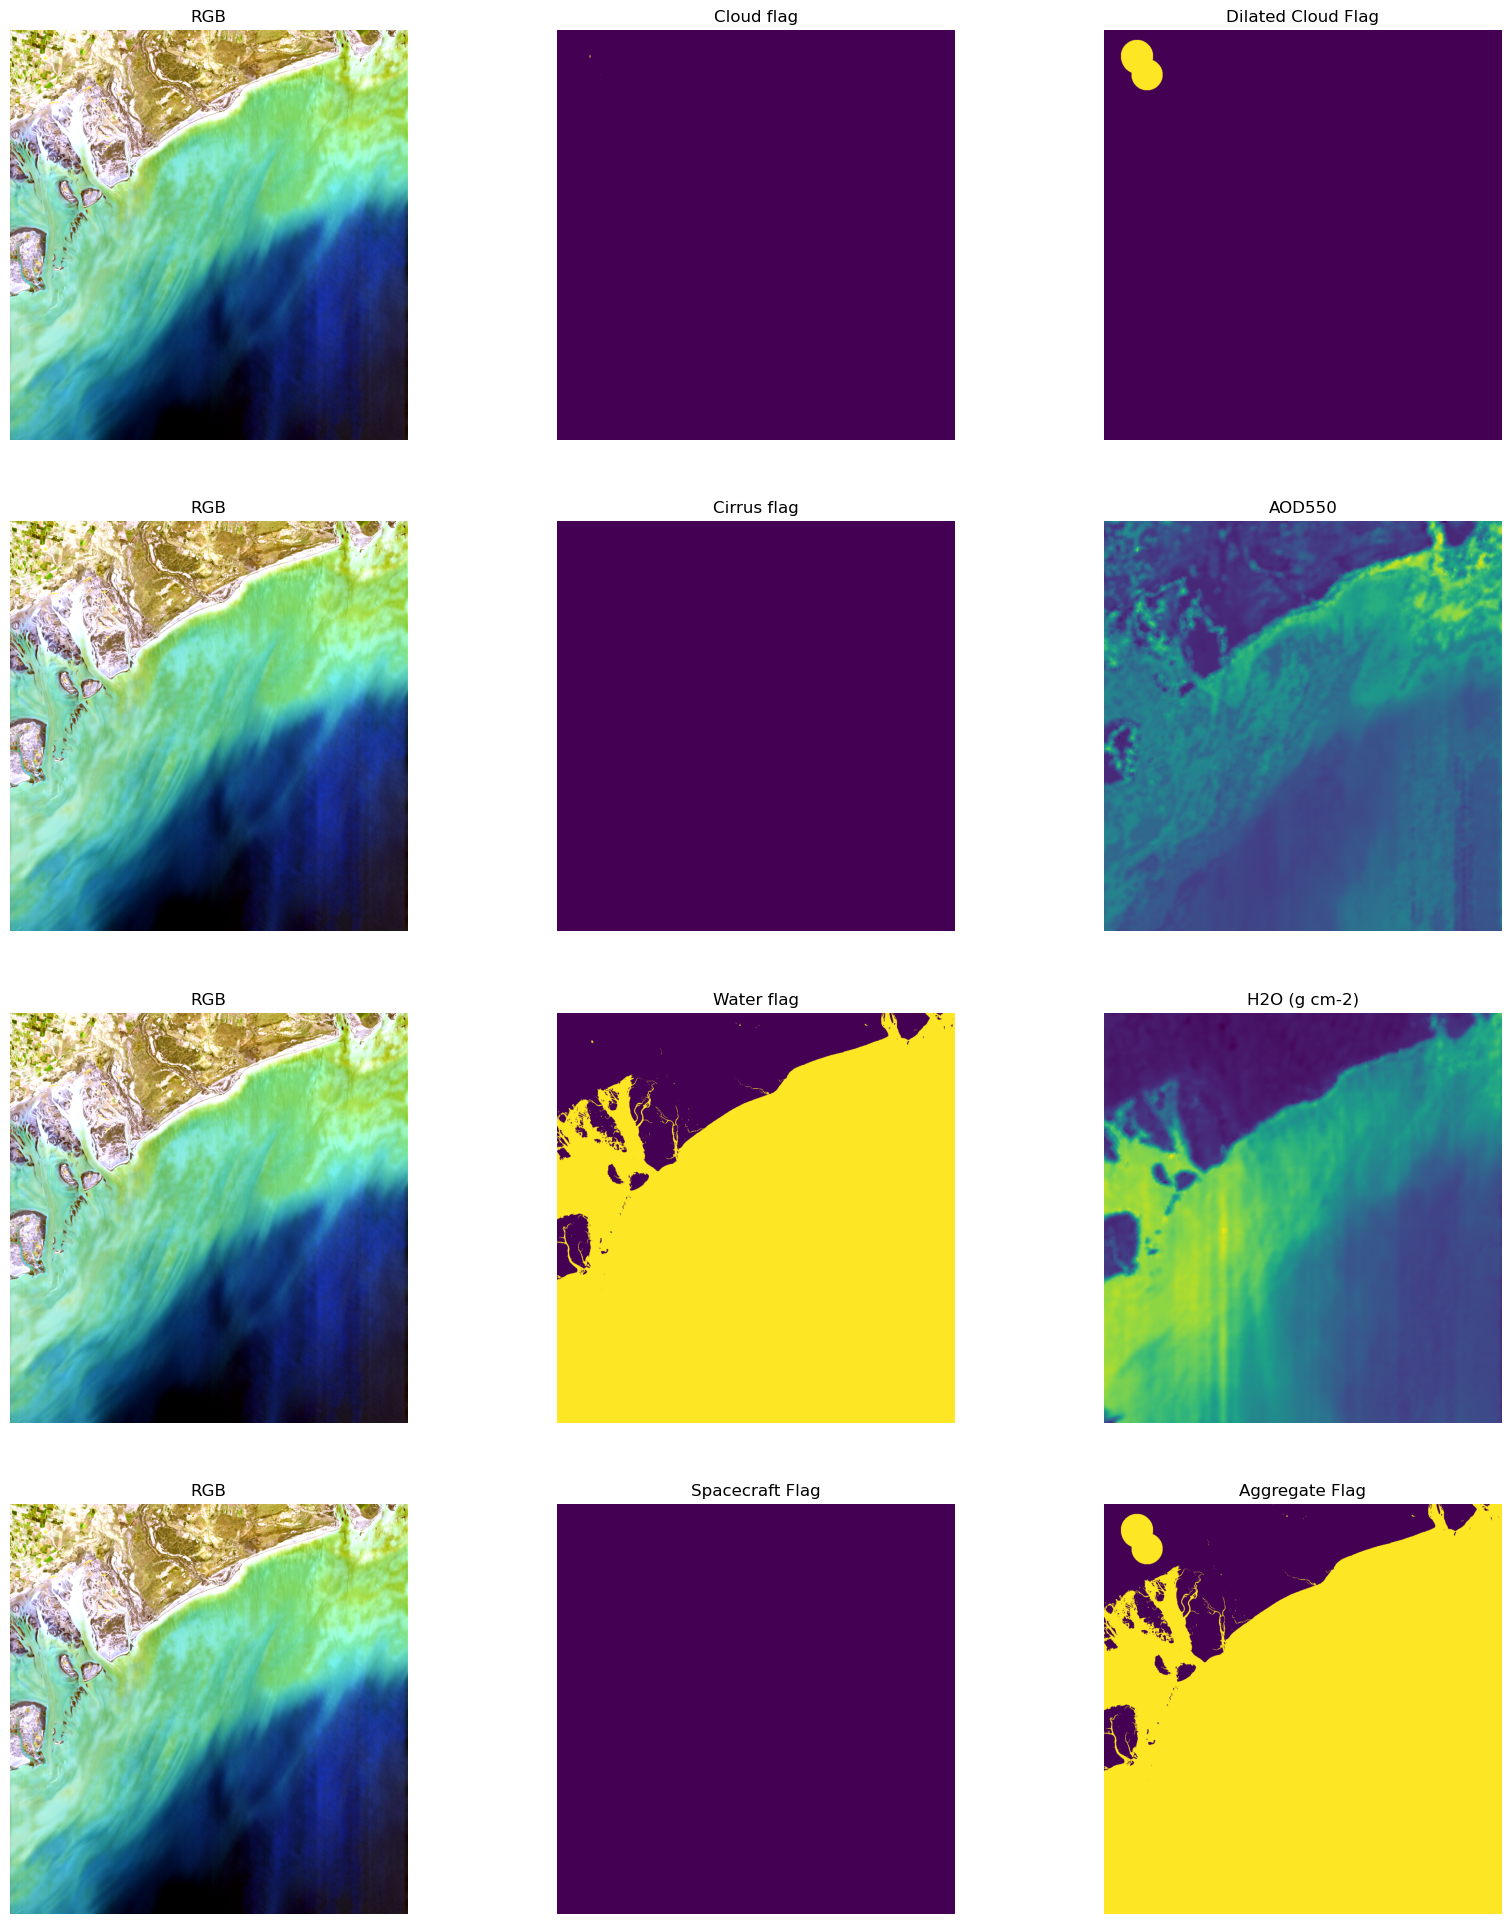

In [6]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(20,50))
gs = gridspec.GridSpec(ncols=3, nrows=len(mask_key), figure=fig)

ds = emit_tools.emit_xarray(fp, ortho = False)
mask_ds = emit_tools.emit_xarray(fp_mask, ortho=False)

rgb_inds = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [650, 560, 470]])
rgb = ds['reflectance'].values[:,:,rgb_inds] # subset RGB
rgb[rgb < 0] = np.nan
rgb -= np.nanpercentile(rgb,2,axis=(0,1))[np.newaxis,np.newaxis,:] # scale from 2-95 %
rgb /= np.nanpercentile(rgb,95,axis=(0,1))[np.newaxis,np.newaxis,:]

for _n in range(int(len(mask_key)/2)):
    ax = fig.add_subplot(gs[_n, 0])
    plt.imshow(rgb);
    plt.axis('off')
    plt.title('RGB')

    ax = fig.add_subplot(gs[_n, 1])
    md = mask_ds['mask'].values[...,_n]
    md[np.isnan(rgb[...,0])] = np.nan
    plt.imshow(md);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n])

    ax = fig.add_subplot(gs[_n, 2])
    md = mask_ds['mask'].values[...,_n+int(len(mask_key)/2)]
    md[np.isnan(rgb[...,0])] = np.nan
    plt.imshow(md);
    plt.axis('off')
    plt.title(mask_key['mask_bands'][_n+int(len(mask_key)/2)])

Some of these bands are direct masks (Cloud, Dilated, Currus, Water, Spacecraft), and some (AOD550 and H2O (g cm-2)) are information calculated during the L2A reflectance retrieval that may be used as additional screening, depending on the application.  The final mask that the EMIT mission will use for its minerological applications is shown as the Aggreged Flag - but not all users might want this particular mask.

Let's take a closer look at some of those bands with additional information, that could be used either to screen specific content out or that might be used as signal:

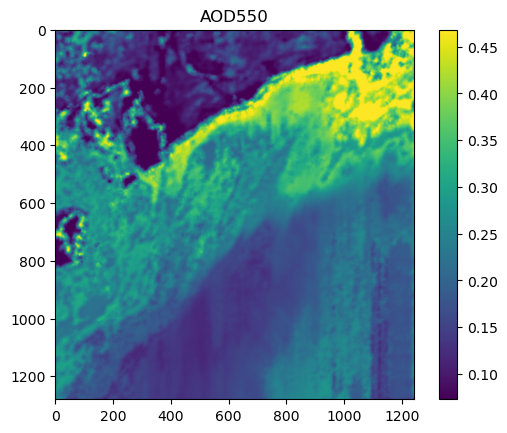

In [7]:
fig = plt.figure()
md = mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('AOD550')]
md[np.isnan(rgb[...,0])] = np.nan
plt.imshow(md, vmin=np.nanpercentile(md,2),vmax=np.nanpercentile(md,98));
plt.title('AOD550')
plt.colorbar()

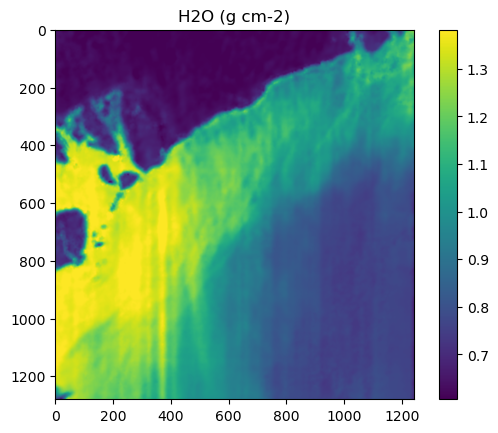

In [8]:
fig = plt.figure()
md = mask_ds['mask'].values[:,:,list(mask_key['mask_bands']).index('H2O (g cm-2)')]
md[np.isnan(rgb[...,0])] = np.nan
plt.imshow(md, vmin=np.nanpercentile(md,2),vmax=np.nanpercentile(md,98));
plt.title('H2O (g cm-2)')
plt.colorbar()

# Applying the Mask

In [9]:
mask_key

,mask_bands
bands,
0,Cloud flag
1,Cirrus flag
2,Water flag
3,Spacecraft Flag
4,Dilated Cloud Flag
5,AOD550
6,H2O (g cm-2)
7,Aggregate Flag


The above dataframe shows exactly what each band contained within the file represents/will mask. For this example we will use flags 0,1,3, and 4 to remove any potential clouds and any artefacts caused by the space station. This can be done using the `quality_mask` function from the `emit_tools` module. This function combines the requested flags into a single mask and returns it as an array.

Select the bands to use.

In [10]:
flags = [0,1,3]
flags

[0, 1, 3]

Now create the mask using the `quality_mask` function.

In [11]:
mask = emit_tools.quality_mask(fp_mask,flags)

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag']


To see the regions of the unorthocorrected image that will be masked we can plot the mask array.

Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag' 'Dilated Cloud Flag']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0385915..13.367763].


Text(0, 0.5, 'Reflectance')

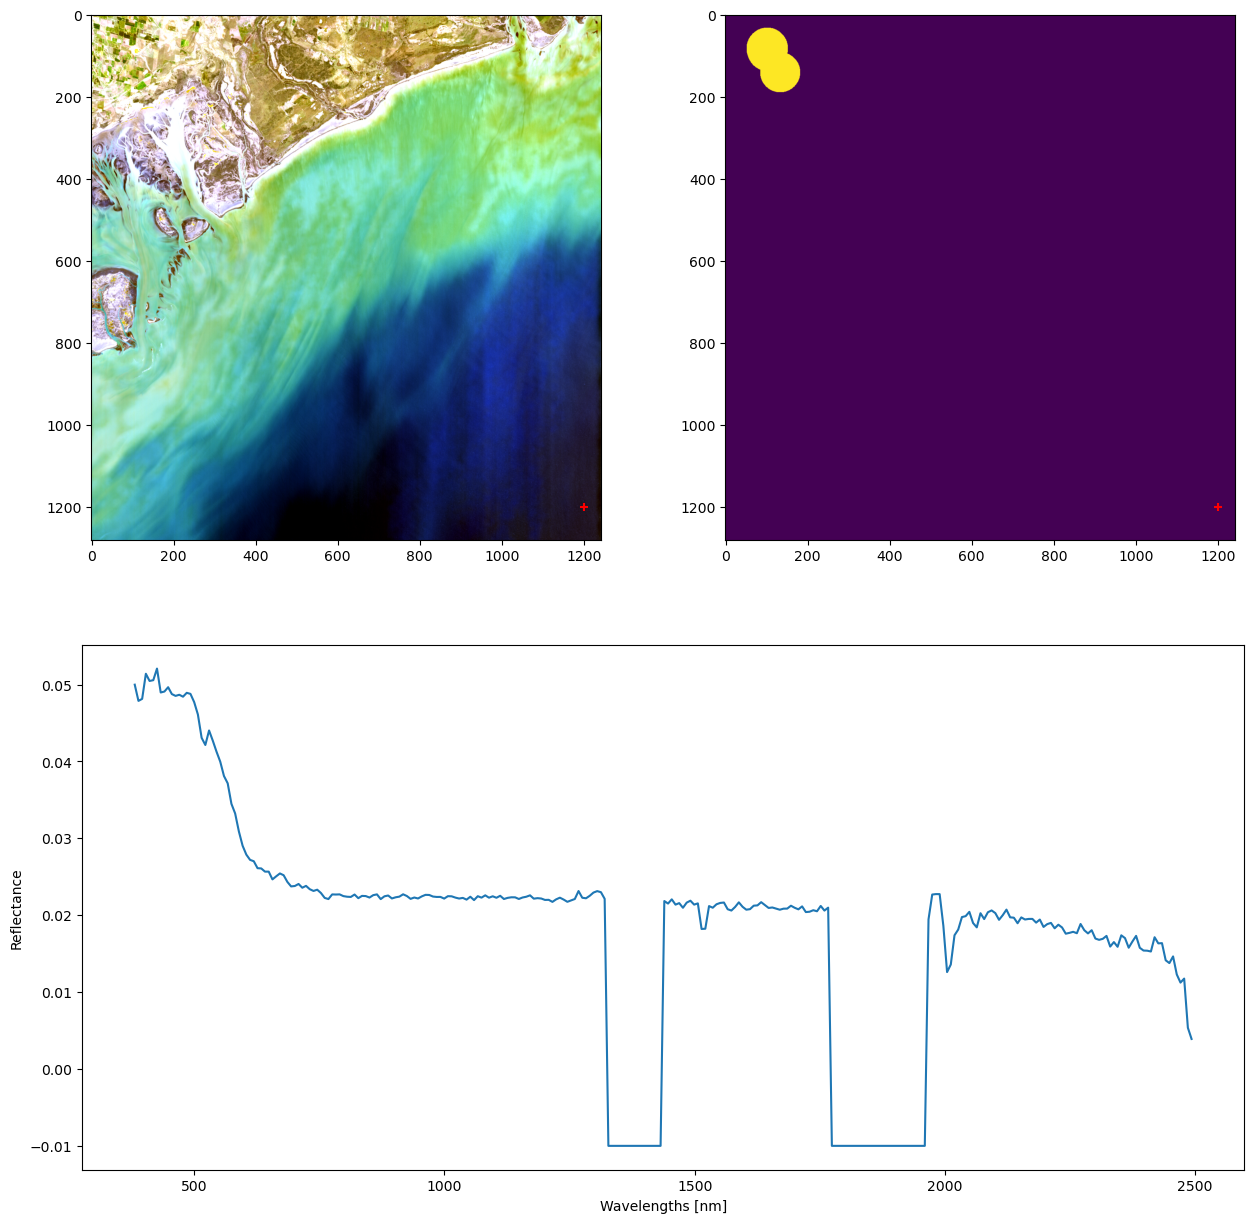

In [12]:
flags = [0,1,3,4]
mask = emit_tools.quality_mask(fp_mask,flags)
fig = plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax = fig.add_subplot(gs[0, 0])
plt.imshow(rgb)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[0, 1])
plt.imshow(mask)
plt.scatter(1200,1200,c='red',marker='+')

ax = fig.add_subplot(gs[1, :])
plt.plot(ds['wavelengths'],ds['reflectance'].values[1200,1200,:])
plt.xlabel('Wavelengths [nm]')
plt.ylabel('Reflectance')

Now that we have a mask to apply, we can use it as the `qmask` parameter in the `emit_xarray` function. 

In [13]:
ds = emit_tools.emit_xarray(fp, ortho=True, qmask=mask)
ds

<xarray.Dataset> Size: 5GB
Dimensions:           (latitude: 2009, longitude: 2353, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB ...
  * latitude          (latitude) float64 16kB -39.31 -39.31 ... -40.4 -40.4
  * longitude         (longitude) float64 19kB -62.51 -62.51 ... -61.24 -61.24
    elev              (latitude, longitude) float32 19MB -9.999e+03 ... -9.99...
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 5GB -9.999e+...
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-6.25120945e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20220903T163129_22246...
    Orthorectified:                    True

This `ds` dataset is now orthorectified and the specified mask has been applied. Visualize the output using a plot of a red band (650 nm).

In [14]:
ds.reflectance.data[ds.reflectance.data == -9999] = np.nan
ds.sel(wavelengths=650, method='nearest').hvplot.image(cmap='viridis', aspect = 'equal', frame_width=500, rasterize=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


BokehModel(combine_events=True, render_bundle={'docs_json': {'b1e95614-589b-4c6a-a8a3-9abacb255527': {'version…

The modified `xarray.Dataset` can also be saved as a netCDF4 output that can be reopened using the `xarray.open_dataset` function.

In [15]:
ds.to_netcdf('../../data/example_quality_nc_out.nc')
# Example for Opening
# ds = xr.open_dataset('../data/example_quality_nc_out.nc')

## 2. Using EMIT Band Mask Data

The EMIT L2A Mask file also contains `band_mask` data, which indicates whether or not any given wavelength of any given pixel is interpolated. Interpolation occurs either due to a focal plane array bad pixel, or from saturation. This data comes as a packed unsigned integer array with 36 elements.

Unpack the data an using the `band_mask` function from the `emit_tools` module. This function will unpack the data and create an array that can be used to mask the bands/pixels when added as an input into the `emit_xarray` function.

In [16]:
bmask = emit_tools.band_mask(fp_mask)
bmask.shape

(1280, 1242, 285)

We can quickly plot an example of a band where some pixels have been interpolated (band 234).

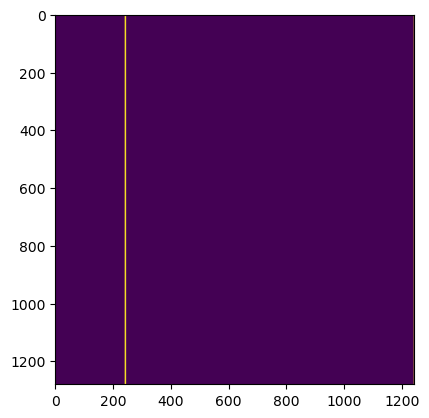

In [17]:
from matplotlib import pyplot as plt
plt.imshow(bmask[:,:,234])

Or more helpfully, plot a representation of the crosstrack of the detector array to see where interpolation is occuring. If your research depends on spectral features contained within these interpolated crosstrack region, you may want to mask them out.

Text(0.5, 0, 'Crosstrack Element')

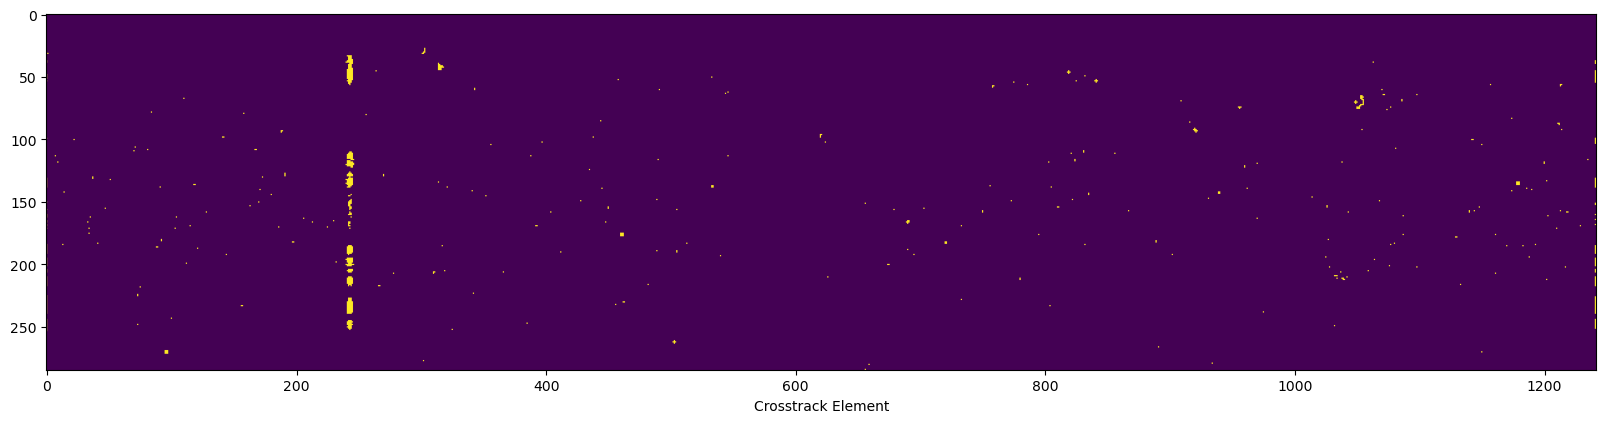

In [18]:
fig = plt.figure(figsize=(20,10))

plt.imshow(bmask[0,...].T)
plt.xlabel('Crosstrack Element')

## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 07-03-2023  

¹Work performed under USGS contract G15PD00467 for NASA contract NNG14HH33I.  